In [1]:
import os
import sys
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
sys.path.insert(0, '../lib')
from ncbi_remap.notebook import Nb
from ncbi_remap.plotting import make_figs

In [2]:
# Setup notebook
nbconfig = Nb.setup_notebook()

Please check output/fbgn2chrom.tsv. If it does not exist, run bin/fbgn2chrom.py
last updated: 2018-10-09 
Git hash: c5425d3c436714fc2475c8e5525cbd28738fd3eb


In [13]:
# Connect to data store
store = pd.HDFStore('../sra.h5', mode='r')

In [15]:
# I only want to focus on the RNA-Seq samples
libstrat = pd.read_parquet('../metadata-wf/output/munge_library_strategy_from_mongo.parquet').iloc[:, 0]
rnaseq = libstrat[libstrat == 'RNA-Seq'].index.tolist()

# Get a list of SRXs that have completed the entire workflow.
srxs = store.select('aln/complete', where='srx == rnaseq').srx.unique().tolist()

In [16]:
ranks = pd.read_csv('../quality-wf/output/rnaseq_srx_quality_ranks.tsv', sep='\t', index_col=0)

In [17]:
# Positive metrics
cols = [
    'num_reads',
    'num_multimappers',
    'per_alignment',
]
hisat2 = store.select('aln/workflow/hisat2', where='srx == srxs', columns=cols)

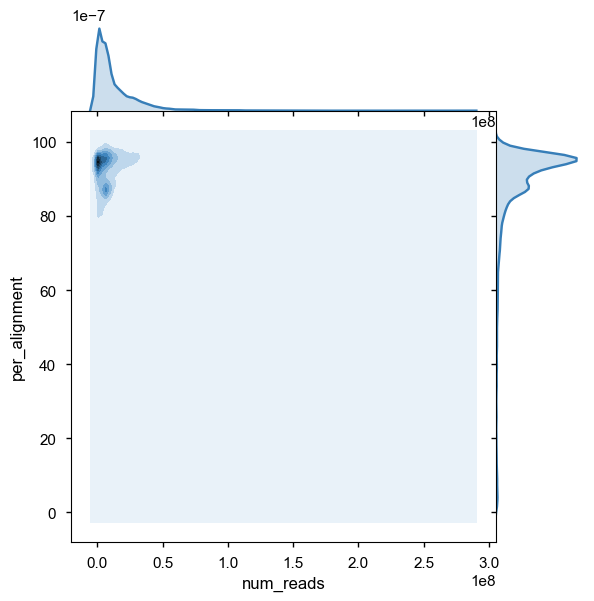

In [18]:
sns.jointplot('num_reads', 'per_alignment', data=hisat2, kind='kde', space=0)

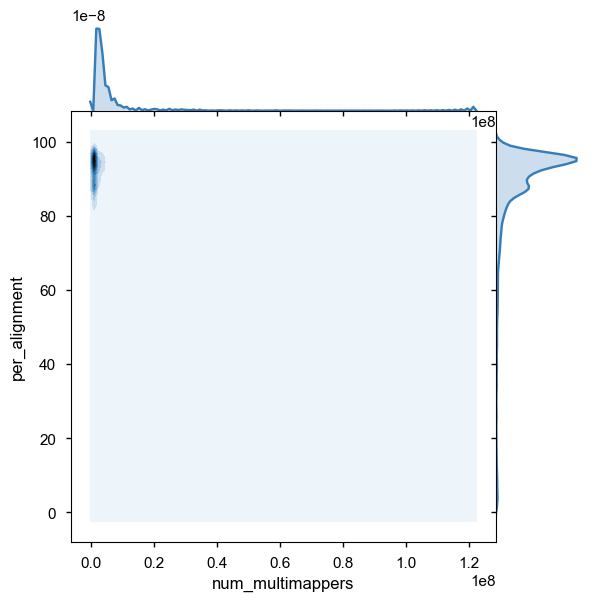

In [19]:
sns.jointplot('num_multimappers', 'per_alignment', data=hisat2, kind='kde', space=0)

In [20]:
# CollectRNASeqMetrics
cols = [
    'PCT_CODING_BASES',
    'PCT_INTERGENIC_BASES'
]
metrics = store.select('prealn/workflow/collectrnaseqmetrics/unstranded', where='srx == srxs', columns=cols)

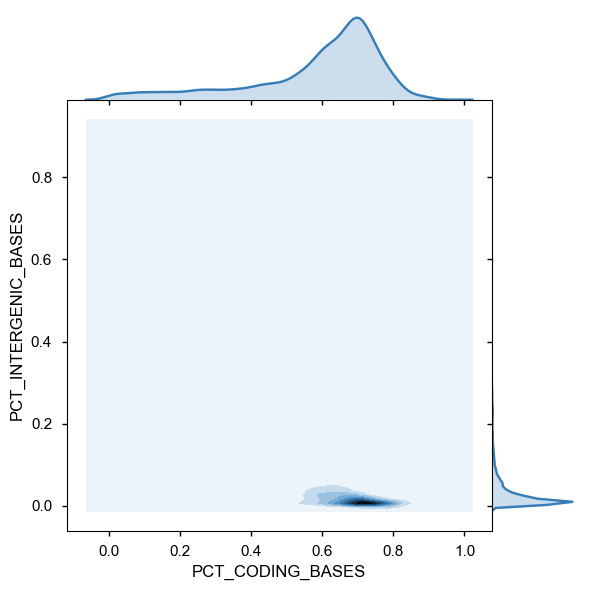

In [21]:
sns.jointplot('PCT_CODING_BASES', 'PCT_INTERGENIC_BASES', data=metrics, kind='kde', space=0)

In [22]:
# Markduplicates
cols = [
    'PERCENT_DUPLICATION',
]
dups = store.select('prealn/workflow/markduplicates', where='srx == srxs', columns=cols)

In [23]:
features = hisat2.join(metrics).join(dups)

In [24]:
features_srx = features.groupby('srx').first()

In [33]:
good = ranks.index[:int(ranks.shape[0] * .3)].tolist()

In [34]:
gd = features_srx.reindex(good)

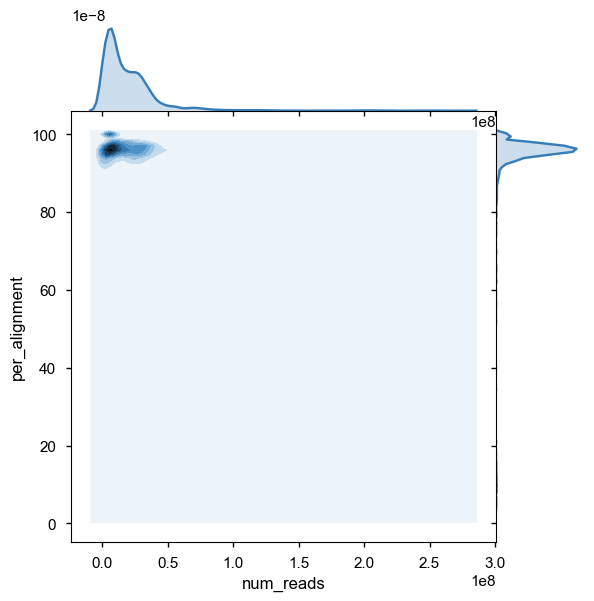

In [35]:
sns.jointplot('num_reads', 'per_alignment', data=gd, kind='kde', space=0)

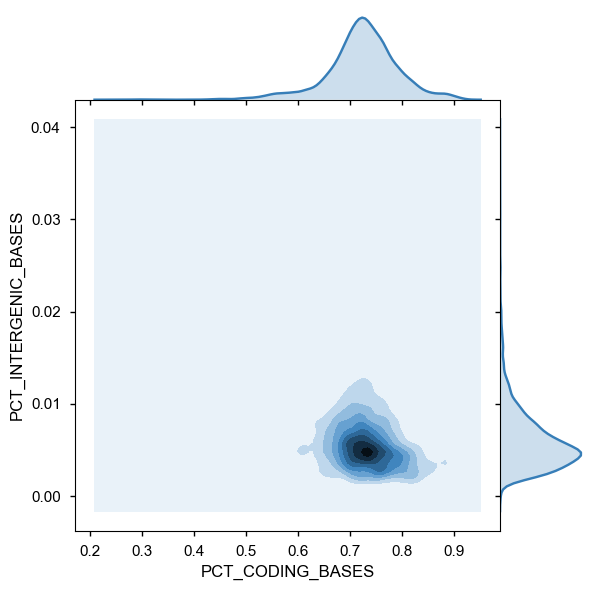

In [36]:
sns.jointplot('PCT_CODING_BASES', 'PCT_INTERGENIC_BASES', data=gd, kind='kde', space=0)